In [20]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from math import *
import time
from IPython import display

from PIL import Image

import pygame

from torchvision.datasets import Omniglot
from torchvision.transforms.functional import affine
DEVICE = "cuda"

In [61]:
class DownBlock(nn.Module):
    def __init__(self, NI, NO):
        super().__init__()
        self.l1 = nn.Conv2d(NI, NO, 3, padding=1, padding_mode='circular')
        self.l2 = nn.Conv2d(NO, NO, 3, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(2)
        self.b = nn.BatchNorm2d(NO)
        
    def forward(self, x):
        z = F.elu(self.l1(x))
        z = self.b(F.elu(self.l2(z)))
        return self.pool(z)

class UpBlock(nn.Module):
    def __init__(self, NI, NO):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.l1 = nn.Conv2d(NI, NO, 3, padding=1, padding_mode='circular')
        self.l2 = nn.Conv2d(NO, NO, 3, padding=1, padding_mode='circular')
        self.b = nn.BatchNorm2d(NI)
        
    def forward(self, x):
        z = self.b(self.upsample(x))
        z = F.elu(self.l1(z))
        return F.elu(self.l2(z))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.down1 = DownBlock(1,16)
        self.down2 = DownBlock(16,32)
        self.down3 = DownBlock(32,64)
        self.down4 = DownBlock(64,128)
        
        self.linter1 = nn.Conv2d(128,128,5,padding=2, padding_mode='circular')
        
        self.bn = nn.BatchNorm2d(128)
        
        self.up4 = UpBlock(128,64)
        self.up3 = UpBlock(64,32)
        self.up2 = UpBlock(32,16)
        self.up1 = UpBlock(16,16)
        self.lfinal = nn.Conv2d(16, 6, 1)
        
        self.optim = torch.optim.Adam(self.parameters(), lr = 1e-4)
        
    def forward(self, x):
        z1 = self.down1(x)
        z2 = self.down2(z1) # 64, RES/4
        z3 = self.down3(z2) # 128, RES/8
        z4 = self.down4(z3) # 256, RES/16
        
        z5 = self.bn(F.elu(self.linter1(z4)))
        
        z7 = z3 + self.up4(z5) # 128, RES/8
        z8 = z2 + self.up3(z7) # 64, RES/4
        z9 = z1 + self.up2(z8) # 32, RES/2
                
        embedding = self.up1(z9)
        z10 = F.log_softmax(self.lfinal(embedding), dim=1)
        
        embedding = (x*embedding).sum(3).sum(2)/x.sum(3).sum(2)
        embedding = embedding/torch.sqrt(1e-8 + torch.sum(embedding**2,1).unsqueeze(1))
        return z10, embedding

In [6]:
omni = Omniglot("/sata/data/omniglot/")

In [22]:
omni_x = []
omni_y = []

for x,y in omni:
    omni_x.append(1-np.array(x.resize((64,64), Image.NEAREST))/255.0)
    omni_y.append(y)

In [24]:
def augment(x):
    z = torch.cuda.FloatTensor(x).unsqueeze(0).unsqueeze(1)
    angle = np.random.randint(30)-15
    translate = (np.random.randint(9)-5, np.random.randint(9)-5)
    shear = (np.random.randint(20)-10, np.random.randint(20)-10)
    scale = np.random.rand()*0.5+0.75
    return affine(z,angle=angle, translate=translate, shear=shear, scale=scale)

In [62]:
net = Net().cuda()

In [58]:
omni_lbl = np.unique(omni_y)

omni_subsets = [np.where(omni_y == y)[0] for y in omni_lbl]

In [60]:
omni_subsets[1]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])

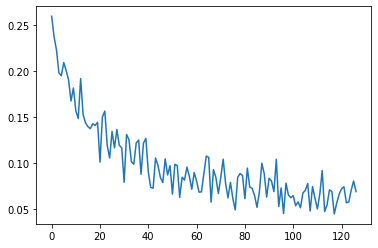

KeyboardInterrupt: 

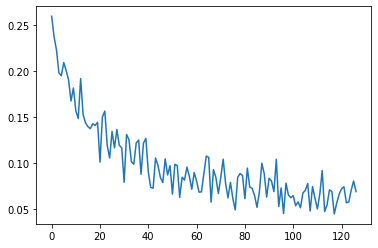

In [63]:
# Pretrain

BS = 100
idx = torch.arange(BS).long()

tr_err = []

lfunc = nn.TripletMarginLoss(margin=0.3)

for epoch in range(100000):
    net.train()
    # Train
    x1 = []
    x2 = []
    x3 = []
    
    for i in range(BS):
        j = np.random.randint(964)
        k = np.random.randint(964)
        
        x1.append(augment(omni_x[omni_subsets[j][np.random.randint(len(omni_subsets[j]))]]))
        x2.append(augment(omni_x[omni_subsets[j][np.random.randint(len(omni_subsets[j]))]]))
        x3.append(augment(omni_x[omni_subsets[k][np.random.randint(len(omni_subsets[k]))]]))
        
    x1 = torch.cat(x1,0)
    x2 = torch.cat(x2,0)
    x3 = torch.cat(x3,0)
    
    x = torch.cat([x1,x2,x3],0)
    
    net.optim.zero_grad()
    p,z = net.forward(x)
    
    z1 = z[:BS]
    z2 = z[BS:2*BS]
    z3 = z[2*BS:3*BS]
    loss = lfunc(z1,z2,z3)
    
    tr_err.append(loss.cpu().detach().item())
    for p in net.parameters():
        loss += torch.mean(p**2)*100
    loss.backward()
    net.optim.step()
    
    plt.clf()
    plt.plot(tr_err)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [64]:
torch.save(net.state_dict(), open("pretrained.pth","wb"))

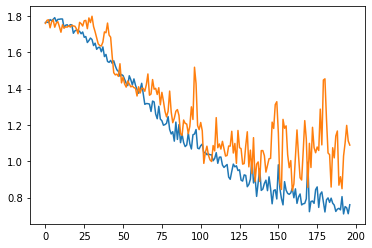

KeyboardInterrupt: 

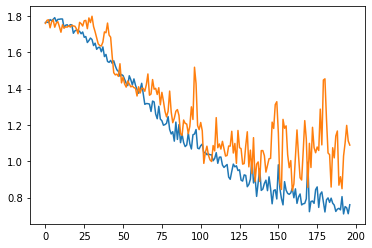

In [66]:
BS = 100
idx = torch.arange(BS).long()

tr_err = []
ts_err = []

for epoch in range(100000):
    net.train()
    # Train
    x = []
    y = []
    for i in range(BS):
        j = np.random.randint(6)
        if j<5:
            k = np.random.randint(10)
            im = 1*(np.array(Image.open("/sata/data/fake_symbols/%d/%.6d.png" % (j+1,k)))[:,:,0]>128)
            x.append(augment(im))
            y.append(j)
        else:
            k = np.random.randint(len(omni_x))
            x.append(augment(omni_x[k]))
            y.append(j)
    x = torch.cat(x,0)
    y = torch.cuda.LongTensor(np.array(y))
    
    net.optim.zero_grad()
    p,z = net.forward(x)
    loss = -torch.sum(p[idx,y[idx],:,:]*x[:,0,:,:])/torch.sum(x)
    tr_err.append(loss.cpu().detach().item())
    for p in net.parameters():
        loss += torch.mean(p**2)*100
    loss.backward()
    net.optim.step()

    net.eval()
    x = []
    y = []
    for i in range(BS):
        j = np.random.randint(6)
        if j<5:
            k = np.random.randint(10)+10
            im = 1*(np.array(Image.open("/sata/data/fake_symbols/%d/%.6d.png" % (j+1,k)))[:,:,0]>128)
            x.append(augment(im))
            y.append(j)
        else:
            k = np.random.randint(len(omni_x))
            x.append(augment(omni_x[k]))
            y.append(j)
    x = torch.cat(x,0)
    y = torch.cuda.LongTensor(np.array(y))
    
    p,z = net.forward(x)
    loss = -torch.sum(p[idx,y[idx],:,:]*x[:,0,:,:])/torch.sum(x)
    ts_err.append(loss.cpu().detach().item())
    
    plt.clf()
    plt.plot(tr_err)
    plt.plot(ts_err)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [67]:
net.eval()

Net(
  (down1): DownBlock(
    (l1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
    (l2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down2): DownBlock(
    (l1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
    (l2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down3): DownBlock(
    (l1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
    (l2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [79]:
torch.save(net.state_dict(), open("symbol_seg.pth","wb"))